In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [2]:
!pip install torch torchvision

In [0]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable

## Load data

In [4]:
# root_folder = 'D:/dev/data/'
root_folder = '~/Download/'

train_dataset = datasets.MNIST(root=root_folder+'mnist/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root=root_folder+'mnist/', train=False, transform=transforms.ToTensor(), download=True)

print('Length of train dataset: {}'.format(len(train_dataset)))
print('Length of test dataset: {}'.format(len(test_dataset)))
print('Shape of each image: {}'.format(train_dataset[0][0].size()))

Processing...
Done!
Length of train dataset: 60000
Length of test dataset: 10000
Shape of each image: torch.Size([1, 28, 28])


## Display MNIST

In [0]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Text(0.5,1,'5')

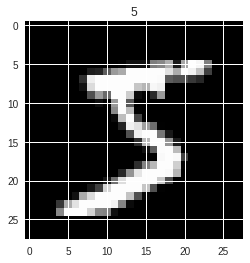

In [6]:
shape = list(train_dataset[0][0].size()[-2:])
show_img = train_dataset[0][0].numpy().reshape(shape)
plt.imshow(show_img, cmap='gray')
plt.title(train_dataset[0][1].numpy())

## Make dataset iterable

In [7]:
batch_size = 100
n_iters = 6000
n_epochs = int(n_iters / (len(train_dataset)/batch_size))

print('Number of epochs: {}'.format(n_epochs))


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Number of epochs: 10


### Check iterability

In [8]:
import collections
isinstance(train_loader, collections.Iterable)
isinstance(test_loader, collections.Iterable)

True

## Build model

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)       
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=128*7*7, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        
        
            
                
    def forward(self, x):
        
        out = self.cnn1(x)            # 16x28x28
        out = self.relu(out)            # 16x28x28        
        out = self.cnn2(out)            # 32x28x28
        out = self.relu(out)            # 32x28x28
        out = self.maxpool(out)         # 32x14x14
        out = self.cnn3(out)            # 64x14x14
        out = self.relu(out)            # 64x14x14
        out = self.cnn4(out)            # 128x14x14
        out = self.relu(out)            # 128x14x14
        out = self.maxpool(out)         # 128x7x7
        out = out.view(out.size(0), -1) # 1x(128*7*7)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out
    
    
    def fit(self, train_loader, criterion, optimizer):
        iteration = 0
        for epoch in range(n_epochs):
            for i, (x, y) in enumerate(train_loader):
              if torch.cuda.is_available():
                x = Variable(x.cuda())
                y = Variable(y.cuda())
              else:
                x = Variable(x)
                y = Variable(y)

              optimizer.zero_grad()
              outputs = self.forward(x)
              print(y.size())
              loss = criterion(outputs, y)
              loss.backward()
              optimizer.step()
                
              iteration += 1

              if iteration%500 == 0:
                  print('Epoch: {}, Iteration: {}, Loss: {}'.format(epoch, iteration, loss))
                  #accuracy = predict(test_loader)
            
            
    
    
    def predict(self, test_loader):
        correct = 0
        total = 0
        first = True
        for x, y in test_loader:
            if torch.cuda.is_available():
              x = Variable(x.cuda())
              y = Variable(y.cuda())
            else:
              x = Variable(x)
              y = Variable(y)

            outputs = self.forward(x)
            if first == True:
              predicted = torch.argmax(outputs, dim=1)
              first = False
            else:
              predicted = torch.cat((predicted, torch.argmax(outputs, dim=1)))
            
        return predicted
        
    def score(self, target, predicted):
        correct = (predicted == target).sum()
        accuracy = np.round(100.*correct/total, 3)
        return accuracy

## Instatiate model

In [0]:
ann = CNN()
if torch.cuda.is_available():
  ann.cuda()

## Instantiate loss class

In [0]:
criterion = nn.CrossEntropyLoss()

## model.parameters() explained

In [12]:
print(ann.parameters())
print(len(list(ann.parameters())))

for parameter in list(ann.parameters()):
    print(parameter.size())

<generator object Module.parameters at 0x7f9f0f5faa40>
12
torch.Size([16, 1, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([500, 6272])
torch.Size([500])
torch.Size([10, 500])
torch.Size([10])


## Optimizer

In [0]:
learning_rate = 0.1
optimizer=torch.optim.SGD(ann.parameters(), lr=learning_rate)

## Training phase

In [14]:
ann.fit(train_loader, optimizer=optimizer, criterion=criterion)        

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])


KeyboardInterrupt: ignored

## Prediction phase

In [0]:
predicted = ann.predict(test_loader)

In [78]:
print(predicted.size())

torch.Size([10000])


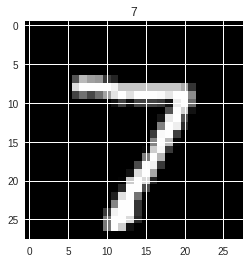

In [77]:
for images, labels in test_loader:
    images = Variable(images.view(-1, 28*28))
    labels = Variable(labels)
    
    plt.imshow(images[0].view(28,28).numpy(), cmap='gray')
    plt.title(labels[0].numpy())
    
    break